In [1]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.13.1
Keras version: 2.1.3


In [2]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True))
K.set_session(sess)

In [4]:
model = load_model(
    "keras-master/examples/image_ocr/2019:05:08:14:27:10/model24.h5", 
    custom_objects={'<lambda>': keras.losses.mse})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [5]:
cutted_model = Model(model.input, model.layers[-1].output)

cutted_model.layers.pop()
cutted_model.layers.pop()
cutted_model.layers.pop()
cutted_model.layers.pop()

cutted_model = Model(cutted_model.input[0], cutted_model.layers[-1].output)

In [6]:
import coremltools

coreml_model = coremltools.converters.keras.convert(cutted_model)

coreml_model.author = "klabertants"
coreml_model.license = "Public Domain"
coreml_model.short_description = "OCR with keras"

#coreml_model.input_description["image"] = "Input image"
#coreml_model.output_description["output"] = "Predicted text"

coreml_model.save("keras_ocr.mlmodel")

0 : the_input, <keras.engine.topology.InputLayer object at 0x7f11f83389e8>
1 : conv1, <keras.layers.convolutional.Conv2D object at 0x7f11f8338a58>
2 : conv1__activation__, <keras.layers.core.Activation object at 0x7f11f8331940>
3 : max1, <keras.layers.pooling.MaxPooling2D object at 0x7f11f8338cf8>
4 : conv2, <keras.layers.convolutional.Conv2D object at 0x7f11f8338d30>
5 : conv2__activation__, <keras.layers.core.Activation object at 0x7f11f83318d0>
6 : max2, <keras.layers.pooling.MaxPooling2D object at 0x7f11f8338f28>
7 : reshape, <keras.layers.core.Reshape object at 0x7f1220da4ba8>
8 : dense1, <keras.layers.core.Dense object at 0x7f11f82d0048>
9 : dense1__activation__, <keras.layers.core.Activation object at 0x7f1197cad1d0>
10 : gru1, <keras.layers.recurrent.GRU object at 0x7f11f82d0198>
11 : gru1_b, <keras.layers.recurrent.GRU object at 0x7f11f82d0400>
12 : add_2, <keras.layers.merge.Add object at 0x7f11f82d05c0>
13 : gru2_b, <keras.layers.recurrent.GRU object at 0x7f11f82d05f8>
14 : 

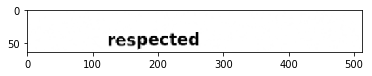

In [7]:
img = cv2.imread("gm.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (512, 64))
img = img.astype(np.float32)
img /= 255

plt.imshow(img, cmap='gray')

In [8]:
imgs = np.zeros((1, 512, 64, 1))
imgs[0, :, :, 0] = img.T

In [9]:
net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

In [10]:
net_out_value = sess.run(net_out, feed_dict={net_inp:imgs})

In [11]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.
alph = 'abcdefghijklmnopqrstuvwxyz '
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        ret.append(alph[np.argmax(out[j, 1:])])
    return [k for k, g in itertools.groupby(ret)]

In [12]:
decode_batch(net_out_value[0])

[' ',
 'q',
 ' ',
 'd',
 ' ',
 'r',
 ' ',
 'o',
 ' ',
 'd',
 ' ',
 'b',
 ' ',
 's',
 ' ',
 'd',
 ' ',
 'c',
 ' ']

In [13]:
"".join(decode_batch(net_out_value[0]))

' q d r o d b s d c '